Total real images: 50000
Total fake images: 50000


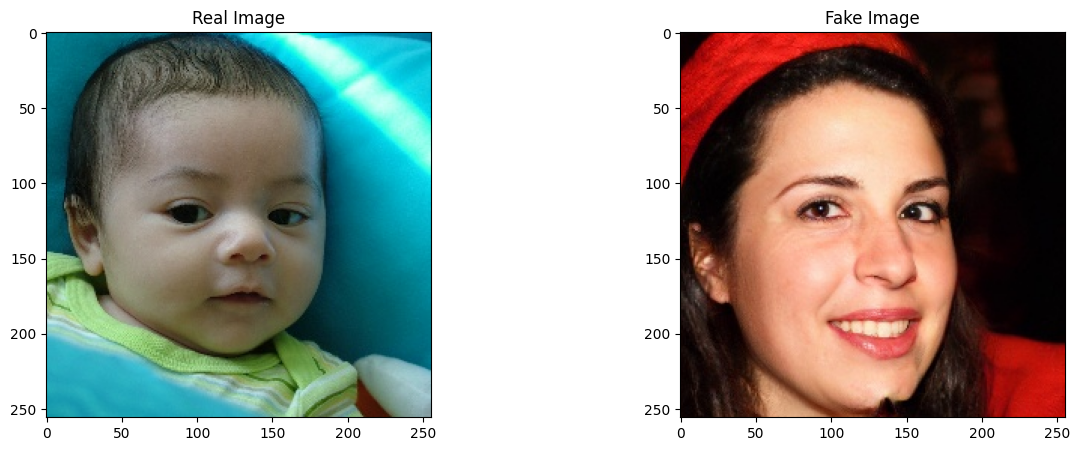

In [4]:
import os
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = './data/Images/real_vs_fake/realvsfake/train'

# Paths for real and fake images
real_path = os.path.join(dataset_path, 'real')
fake_path = os.path.join(dataset_path, 'fake')

# List image files
real_images = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
fake_images = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Print total number of images
print(f"Total real images: {len(real_images)}")
print(f"Total fake images: {len(fake_images)}")

# Example: Display first few images
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Real Image')
plt.imshow(plt.imread(real_images[0]))
plt.subplot(1,2,2)
plt.title('Fake Image')
plt.imshow(plt.imread(fake_images[0]))
plt.show()